In [24]:
from dotenv import load_dotenv
import os
import itertools
import requests
import pandas as pd
import re
from IPython.core.display import HTML
#!pip install thefuzz
from thefuzz import fuzz, process

# !pip install matplotlib
# !pip install pandas
# !pip install wordcloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import spacy
from collections import Counter


# Utilized https://github.com/wjakethompson/taylor

In [2]:
# songs_subset favors Taylor's Version over original, exludes remixes, demos, acoustic, and pop versions of songs. This eliminates duplication of lyrics in analysis.
# Removed songs placed in songs_subset_removed

# Load the data
df = pd.read_csv('taylor_song_sound_data_updated.csv')

## Data Cleaning

In [3]:
# Create dataframe with null lyrics
df_nan_lyrics = df[df['lyrics'].isnull()]
df_nan_lyrics.shape

(94, 29)

In [4]:
# Which songs have null lyrics
df_nan_songs = df_nan_lyrics['track_name'].unique()
list(df_nan_songs)

# Note that the dataset contains original and Taylor's Versions of songs. There are a few Taylor's Versions in this null set (i.e. Forever & Always (Piano Version) [Taylor's Version]) but the Taylor's Version is still part of the full dataset

['Teardrops On My Guitar (Pop Version)',
 'Fearless',
 'Fifteen',
 'Love Story',
 'Hey Stephen',
 'White Horse',
 'You Belong With Me',
 'Breathe',
 'Tell Me Why',
 "You're Not Sorry",
 'The Way I Loved You',
 'Forever & Always',
 'The Best Day',
 'Change',
 'Jump Then Fall',
 'Untouchable',
 'Forever & Always (Piano Version)',
 'Come In With The Rain',
 'SuperStar',
 'The Other Side Of The Door',
 "Forever & Always (Piano Version) [Taylor's Version]",
 'Mine',
 'Sparks Fly',
 'Back To December',
 'Speak Now',
 'Dear John',
 'Mean',
 'The Story Of Us',
 'Never Grow Up',
 'Enchanted',
 'Better Than Revenge',
 'Innocent',
 'Haunted',
 'Last Kiss',
 'Long Live',
 'Ours',
 'If This Was A Movie',
 'Superman',
 'State Of Grace',
 'Red',
 'I Knew You Were Trouble',
 'All Too Well',
 '22',
 'I Almost Do',
 'We Are Never Ever Getting Back Together',
 'Stay Stay Stay',
 'The Last Time',
 'Holy Ground',
 'Sad Beautiful Tragic',
 'The Lucky One',
 'Everything Has Changed',
 'Starlight',
 'Begin Ag

In [5]:
# Check if there's any lyrics less than 100 characters to catch any errors
df_check = df[df['lyrics'].str.len() <100]
print(df_check)

Empty DataFrame
Columns: [album_name, ep, album_release, track_number, track_name, artist, featuring, bonus_track, promotional_release, single_release, track_release, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, time_signature, duration_ms, explicit, key_name, mode_name, key_mode, lyrics]
Index: []

[0 rows x 29 columns]


In [6]:
# Display shape of dataframe to compare in next step
df.shape

(325, 29)

In [7]:
# Find indices of rows with null lyrics
index_nan_lyrics = df[df['lyrics'].isnull()].index

# Drop these rows from the DataFrame
df.drop(index_nan_lyrics, inplace=True)

# Display shape of dataframe to confirm that rows were dropped
df.shape

(231, 29)

In [8]:
# Look for any duplicated songs using thefuzz

# I originally ran thefuzz and (Taylor's Version) and [From The Vault] resulted in high similarity. So I'm subbing it out for the similarity check
def remove_taylors_version(track_name):
    track_name = re.sub(r"\(Taylor's Version\)", "", track_name)
    track_name = re.sub(r"\[From The Vault]","", track_name)
    return track_name

def similar_song_ranking(df):
    df['processed_track_name'] = df['track_name'].apply(remove_taylors_version)
    
    # Create a list to store the similarity data
    similarity_data = []

    # Create all unique pairs of tracks
    for track1, track2 in itertools.combinations(df['processed_track_name'].unique(), 2):
        # Calculate the similarity score between each pair of tracks
        score = fuzz.ratio(track1, track2)
        similarity_data.append({'track1': track1, 'track2': track2, 'similarity': score})

    # Convert the list to a DataFrame
    similarity_df = pd.DataFrame(similarity_data)

    # Sort the DataFrame based on the similarity score, in descending order
    similarity_df.sort_values(by='similarity', ascending=False, inplace=True)

    return similarity_df

In [9]:
similarity_ranking_df = similar_song_ranking(df)
similarity_ranking_df.head(10)

track1            track2  similarity
12203           Treacherous      Treacherous           96
12387          Girl At Home     Girl At Home           96
16847                 Clean            Clean           91
26163        Last Christmas   White Christmas          76
20887      King Of My Heart  Half Of My Heart          75
6488             SuperStar          Superman           74
26315        Beautiful Eyes  Beautiful Ghosts          73
9233                  Mean             Clean           73
7915            Don't You      Say Don't Go            72
9946   Better Than Revenge       Better Man            69

In [10]:
string = ["Treacherous", "Girl At Home", "Clean"]

df[df['track_name'].str.contains('|'.join(string))]

album_name     ep album_release  track_number  \
101                      Red  False    10/22/2012           3.0   
117                      Red  False    10/22/2012          19.0   
123   Red (Taylor's Version)  False    11/12/2021           3.0   
139   Red (Taylor's Version)  False    11/12/2021          19.0   
163                     1989  False    10/27/2014          13.0   
179  1989 (Taylor's Version)  False    10/27/2023          13.0   

                          track_name        artist featuring bonus_track  \
101                      Treacherous  Taylor Swift       NaN       False   
117                     Girl At Home  Taylor Swift       NaN        True   
123   Treacherous (Taylor's Version)  Taylor Swift       NaN       False   
139  Girl At Home (Taylor's Version)  Taylor Swift       NaN       False   
163                            Clean  Taylor Swift       NaN       False   
179         Clean (Taylor's Version)  Taylor Swift       NaN       False   

    promotional_release single_release  ... valence    tempo  time_signature  \
101                 NaN            NaN  ...   0.395  109.993             4.0   
117                 NaN            NaN  ...   0.633  125.048             4.0   
123                 NaN            NaN  ...   0.299  109.984             4.0   
139                 NaN            NaN  ...   0.612  125.089             4.0   
163                 NaN            NaN  ...   0.211  103.970             4.0   
179                 NaN            NaN  ...   0.258  103.955             4.0   

     duration_ms  explicit  key_name  mode_name  key_mode  \
101     240773.0     False         D      major   D major   
117     220320.0     False         F      major   F major   
123     242720.0     False         D      major   D major   
139     220520.0     False         F      major   F major   
163     271000.0     False         E      major   E major   
179     271000.0     False         E      major   E major   

                                                lyrics  processed_track_name  
101  Put your lips close to mine As long as they do...           Treacherous  
117  Don't look at me, you got a girl at home And e...          Girl At Home  
123  Put your lips close to mine As long as they do...          Treacherous   
139  Don't look at me, you got a girl at home And e...         Girl At Home   
163  The drought was the very worst (Oh-oh, oh-oh) ...                 Clean  
179  The drought was the very worst, ah-ah, ah-ah W...                Clean   

[6 rows x 30 columns]

In [11]:
# All dupliate songs are non-Taylor's Version
# Drop non-Taylor's version of songs

drop_songs = df['track_name'].isin(string) & ~df['track_name'].str.contains("Taylor's Version", na=False)
df.drop(df[drop_songs].index, inplace=True)

## Data Preprocessing & Some Extra Cleaning

In [12]:
#!python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md')

In [13]:
# Group lyrics into albums

df_albums = df.groupby('album_name')['lyrics'].apply(lambda x: ' '.join(x.astype(str)))
df_albums = df_albums.to_frame()
df_albums

lyrics
album_name                                                                            
1989 (Taylor's Version)              Walkin' through a crowd, the village is aglow ...
Beautiful Eyes                       Your beautiful eyes Stare right into my eyes A...
Fearless (Taylor's Version)          There's something 'bout the way The street loo...
Lover                                How many days did I spend thinking 'Bout how y...
Midnights                            Meet me at midnight Staring at the ceiling wit...
Red (Taylor's Version)               I'm walkin' fast through the traffic lights Bu...
Speak Now (Taylor's Version)         Ah-ah, ah-ah Ah-ah, ah-ah You were in college ...
Taylor Swift                         He said the way my blue eyes shined Put those ...
The Taylor Swift Holiday Collection  Last Christmas I gave you my heart But the ver...
evermore                             I'm like the water when your ship rolled in th...
folklore                             I'm doing good, I'm on some new shit Been sayi...
reputation                           Knew he was a killer first time that I saw him...

In [14]:
# Drop the Holiday album as Taylor Swift has not written any of the songs
df_albums.drop(['The Taylor Swift Holiday Collection'], axis=0, inplace = True)

In [15]:
# Look at how many words each ablum is
df_albums['lyrics'].apply(len)

album_name
1989 (Taylor's Version)         46219
Beautiful Eyes                   2320
Fearless (Taylor's Version)     41533
Lover                           33540
Midnights                       36502
Red (Taylor's Version)          50011
Speak Now (Taylor's Version)    44053
Taylor Swift                    19734
evermore                        29985
folklore                        25731
reputation                      35444
Name: lyrics, dtype: int64

In [16]:
# Tokenization, lemmatization, and removal of stop words

# Lemmatization should help give a better portrayl of which root words are utilized and repeated

def tokenize(lyrics):
    doc = nlp(lyrics)
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
    return tokens

def lemmatize(lyrics):
    doc = nlp(lyrics)
    lemmas = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return lemmas

df_albums['tokenized_lyrics'] = df_albums['lyrics'].apply(tokenize)
df_albums['lemmatized_lyrics'] = df_albums['lyrics'].apply(lemmatize)
df_albums.head()

lyrics  \
album_name                                                                       
1989 (Taylor's Version)      Walkin' through a crowd, the village is aglow ...   
Beautiful Eyes               Your beautiful eyes Stare right into my eyes A...   
Fearless (Taylor's Version)  There's something 'bout the way The street loo...   
Lover                        How many days did I spend thinking 'Bout how y...   
Midnights                    Meet me at midnight Staring at the ceiling wit...   

                                                              tokenized_lyrics  \
album_name                                                                       
1989 (Taylor's Version)      [Walkin, crowd, village, aglow, Kaleidoscope, ...   
Beautiful Eyes               [beautiful, eyes, Stare, right, eyes, think, l...   
Fearless (Taylor's Version)  [way, street, looks, rained, glow, pavement, w...   
Lover                        [days, spend, thinking, Bout, wrong, wrong, wr...   
Midnights                    [Meet, midnight, Staring, ceiling, Oh, read, m...   

                                                             lemmatized_lyrics  
album_name                                                                      
1989 (Taylor's Version)      [walkin, crowd, village, aglow, Kaleidoscope, ...  
Beautiful Eyes               [beautiful, eye, stare, right, eye, think, lat...  
Fearless (Taylor's Version)  [way, street, look, rain, glow, pavement, walk...  
Lover                        [day, spend, think, bout, wrong, wrong, wrong,...  
Midnights                    [meet, midnight, stare, ceiling, oh, read, mel...

In [17]:
df_albums['tokenized_lyrics']

album_name
1989 (Taylor's Version)         [Walkin, crowd, village, aglow, Kaleidoscope, ...
Beautiful Eyes                  [beautiful, eyes, Stare, right, eyes, think, l...
Fearless (Taylor's Version)     [way, street, looks, rained, glow, pavement, w...
Lover                           [days, spend, thinking, Bout, wrong, wrong, wr...
Midnights                       [Meet, midnight, Staring, ceiling, Oh, read, m...
Red (Taylor's Version)          [walkin, fast, traffic, lights, Busy, streets,...
Speak Now (Taylor's Version)    [Ah, ah, ah, ah, Ah, ah, ah, ah, college, work...
Taylor Swift                    [said, way, blue, eyes, shined, Georgia, stars...
evermore                        [like, water, ship, rolled, night, Rough, surf...
folklore                        [good, new, shit, saying, yes, instead, though...
reputation                      [Knew, killer, time, saw, Wondered, girls, lov...
Name: tokenized_lyrics, dtype: object

In [18]:
# Perform same process on all songs

all_lyrics_lemmatized = ' '.join(df_albums['lemmatized_lyrics'].sum())

In [19]:
# What's the length of the tokenized version
df_albums['tokenized_lyrics'].apply(len)

album_name
1989 (Taylor's Version)         3677
Beautiful Eyes                   164
Fearless (Taylor's Version)     2991
Lover                           2705
Midnights                       2850
Red (Taylor's Version)          3857
Speak Now (Taylor's Version)    3266
Taylor Swift                    1434
evermore                        2385
folklore                        1893
reputation                      2732
Name: tokenized_lyrics, dtype: int64

In [20]:
# Look at the difference between lyrics and their tokenized version
length_difference = df_albums['lyrics'].apply(len) - df_albums['tokenized_lyrics'].apply(len)
length_difference

album_name
1989 (Taylor's Version)         42542
Beautiful Eyes                   2156
Fearless (Taylor's Version)     38542
Lover                           30835
Midnights                       33652
Red (Taylor's Version)          46154
Speak Now (Taylor's Version)    40787
Taylor Swift                    18300
evermore                        27600
folklore                        23838
reputation                      32712
dtype: int64

In [21]:
# What percent of tokens are remaining after tokenization and removing stop words
length_difference_percent = df_albums['tokenized_lyrics'].apply(len) / df_albums['lyrics'].apply(len)
round(length_difference_percent*100,1)

album_name
1989 (Taylor's Version)         8.0
Beautiful Eyes                  7.1
Fearless (Taylor's Version)     7.2
Lover                           8.1
Midnights                       7.8
Red (Taylor's Version)          7.7
Speak Now (Taylor's Version)    7.4
Taylor Swift                    7.3
evermore                        8.0
folklore                        7.4
reputation                      7.7
dtype: float64

## Descriptive Analysis
- What words and/or phrases are repeated in each album and throughout all albums?
- How varied is the vocabulary used across different albums?

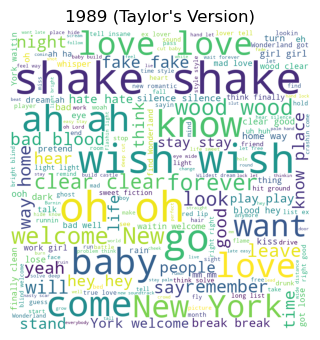

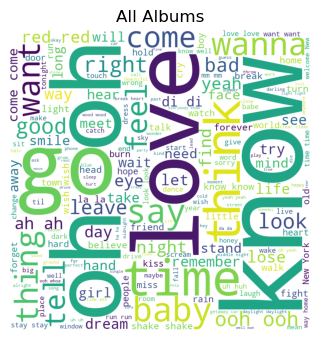

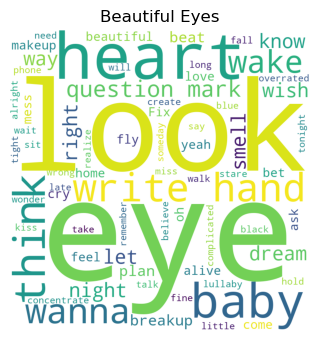

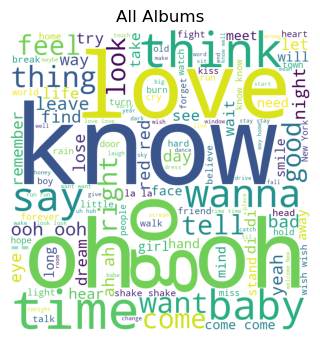

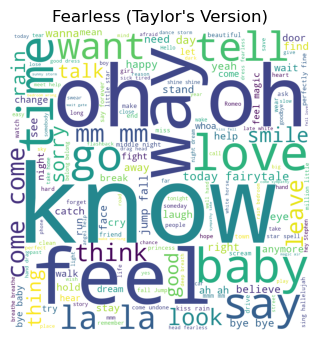

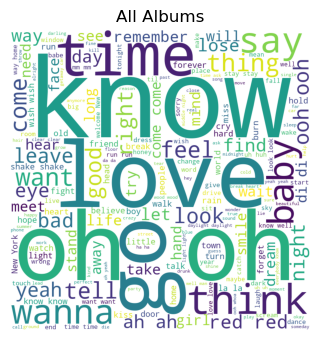

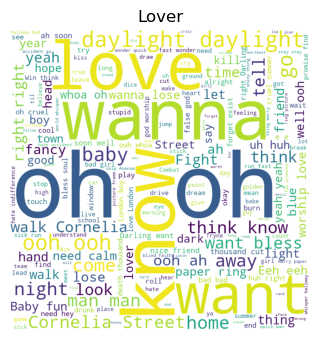

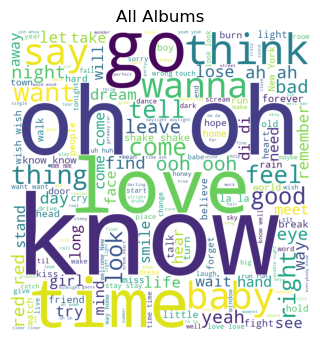

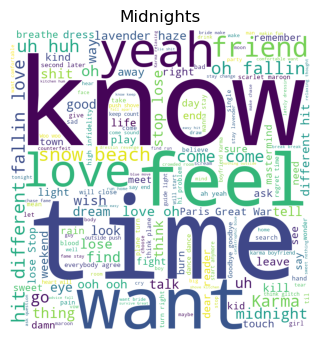

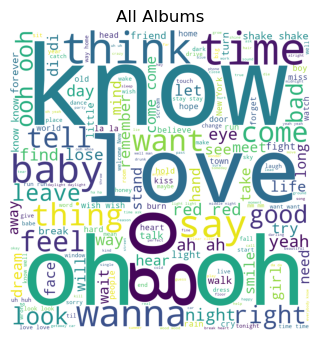

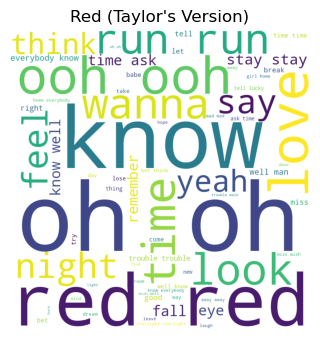

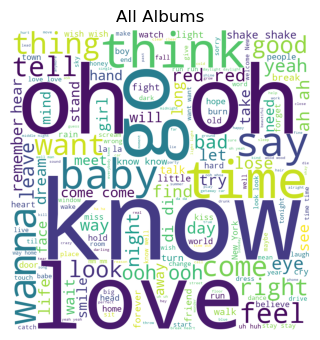

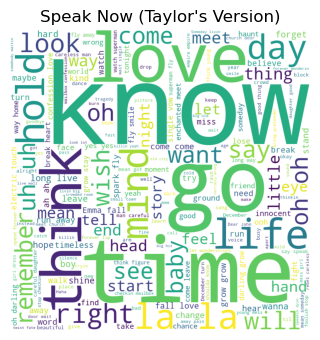

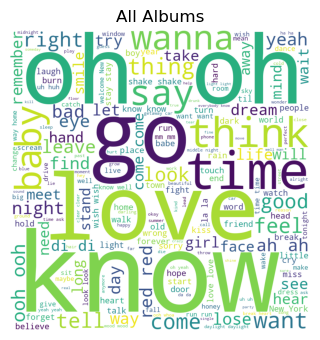

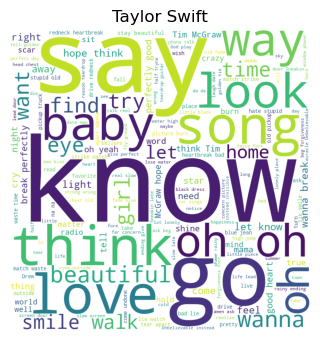

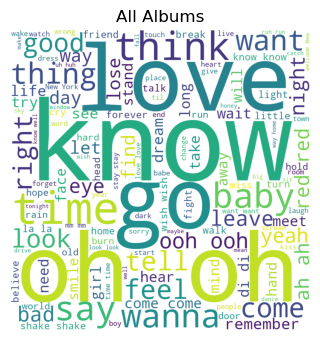

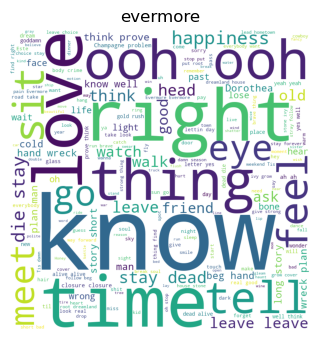

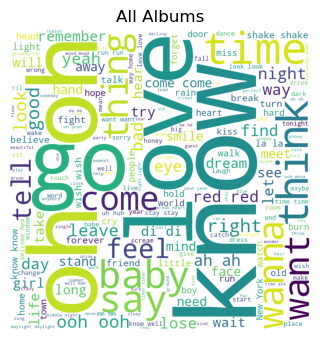

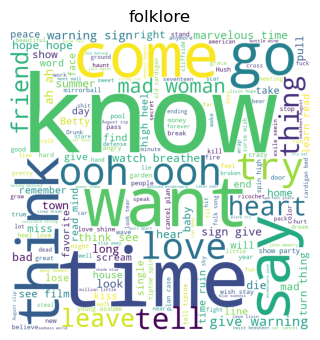

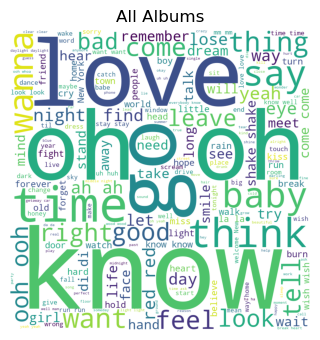

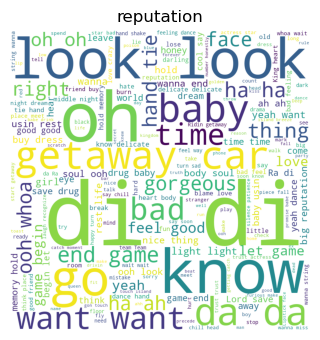

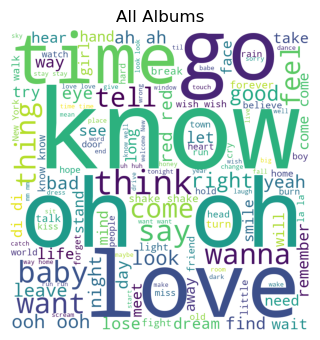

In [33]:
# Word cloud

def create_word_cloud(text, title):
    word_cloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)
    
    # Plot word cloud
    plt.figure(figsize=(3,3), facecolor=None)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title)
    plt.show()

for album_name, data in df_albums.iterrows():
    all_lyrics = ' '.join(data['lemmatized_lyrics'])
    create_word_cloud(all_lyrics, album_name)

    
    all_albums_lyrics = ' '.join(df_albums['lemmatized_lyrics'].sum())
    create_word_cloud(all_albums_lyrics, "All Albums")

In [38]:
# Flatten the list of lists
all_lemmatized_words = [word for sublist in df_albums['lemmatized_lyrics'] for word in sublist]

# Count the frequency of each word
for album_name, data in df_albums.iterrows():
    all_lyrics = ' '.join(data['lemmatized_lyrics'])
    count_all_lyrics = Counter(all_lyrics)
    print(sum(count_all_lyrics.values()))

    
    all_albums_lyrics = ' '.join(df_albums['lemmatized_lyrics'].sum())
    count_all_albums_lyrics = Counter(all_albums_lyrics)
    print(sum(count_all_albums_lyrics.values()))
    

20187
156517
912
156517
16512
156517
14989
156517
16848
156517
21123
156517
18692
156517
7898
156517
13695
156517
11004
156517
14647
156517


In [40]:
from collections import Counter

# Count the frequency of each word for each album
for album_name, data in df_albums.iterrows():
    # Use the list of lemmatized words directly
    count_album_lyrics = Counter(data['lemmatized_lyrics'])
    print(f"Word count for {album_name}:")
    for word, count in count_album_lyrics.most_common(20):
        print(f"{word}: {count}")

# Optional: Count words across all albums
all_albums_words = [word for sublist in df_albums['lemmatized_lyrics'] for word in sublist]
count_all_albums_lyrics = Counter(all_albums_words)
print("\nTotal word count across all albums:")
for word, count in count_all_albums_lyrics.most_common(20):
    print(f"{word}: {count}")


Word count for 1989 (Taylor's Version):
oh: 124
love: 110
wish: 77
ah: 70
shake: 70
know: 60
go: 58
like: 52
get: 52
come: 45
wood: 38
hey: 37
clear: 37
stay: 37
think: 36
bad: 36
to: 36
want: 33
baby: 31
New: 30
Word count for Beautiful Eyes:
eye: 9
look: 8
heart: 8
baby: 6
think: 5
write: 5
hand: 5
wanna: 4
wake: 4
question: 4
mark: 4
right: 3
night: 3
know: 3
way: 3
let: 3
dream: 3
wish: 3
smell: 3
breakup: 3
Word count for Fearless (Taylor's Version):
oh: 104
know: 99
come: 67
like: 51
feel: 51
love: 43
way: 41
get: 41
baby: 41
say: 40
time: 39
go: 32
tell: 30
mm: 30
rain: 28
bye: 26
want: 25
think: 24
fall: 24
night: 23
Word count for Lover:
oh: 102
like: 71
ooh: 64
know: 52
want: 52
love: 45
daylight: 38
wanna: 34
think: 33
man: 31
ah: 29
go: 28
right: 28
yeah: 23
walk: 21
bad: 20
get: 20
to: 20
come: 19
need: 19
Word count for Midnights:
like: 68
love: 43
oh: 37
come: 37
want: 33
know: 31
time: 30
lose: 28
yeah: 26
uh: 26
feel: 21
different: 21
think: 19
find: 18
friend: 18
danc

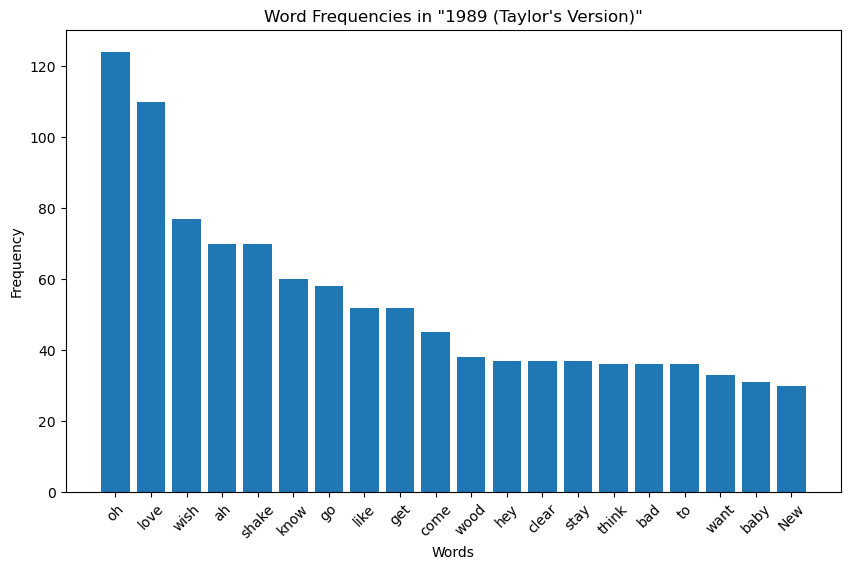

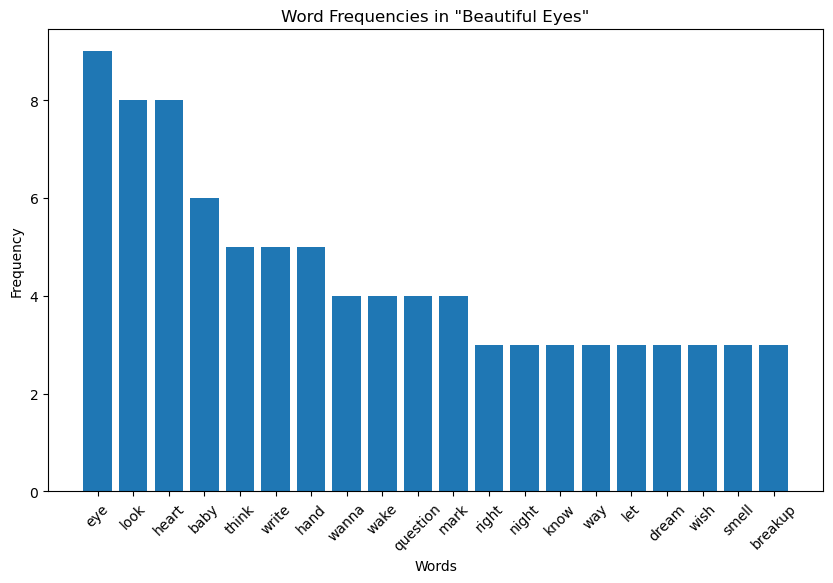

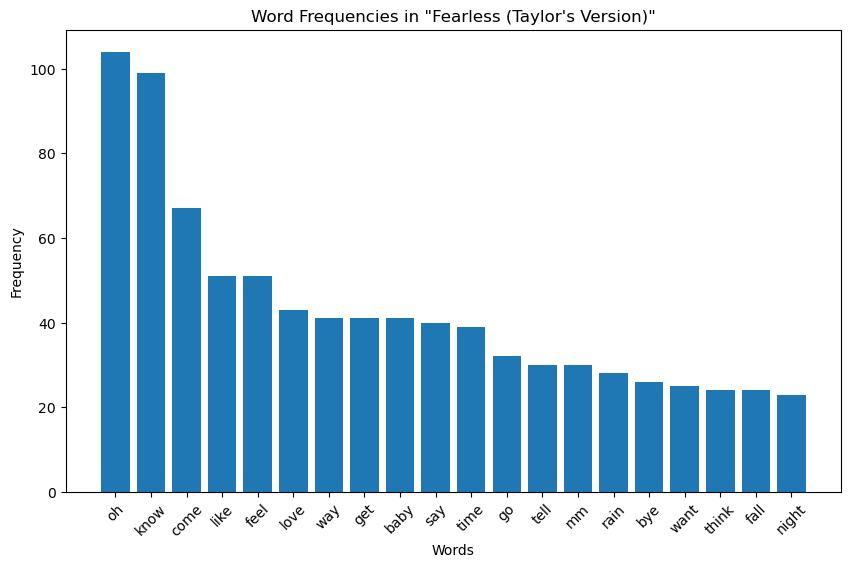

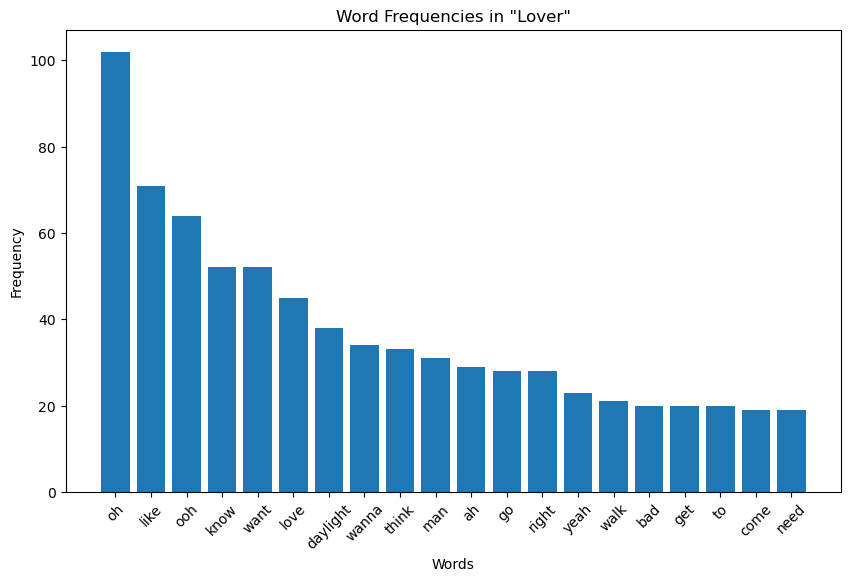

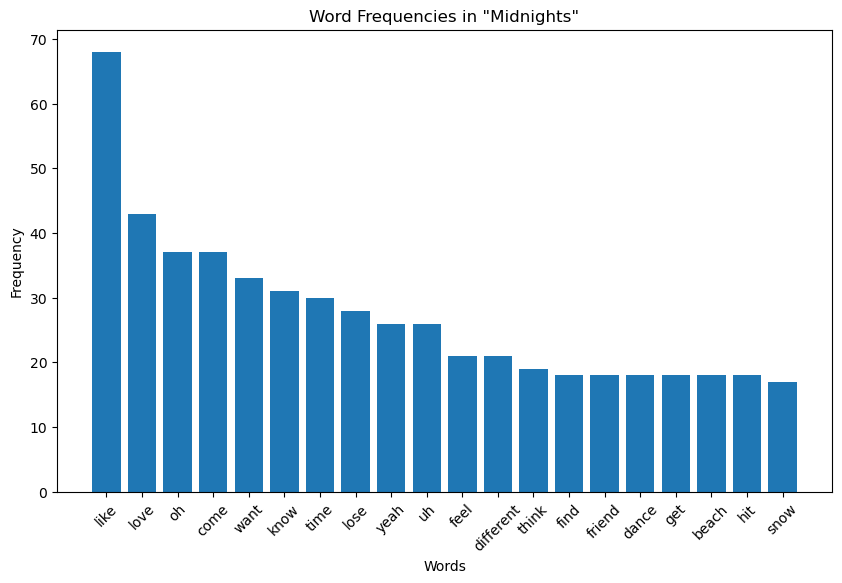

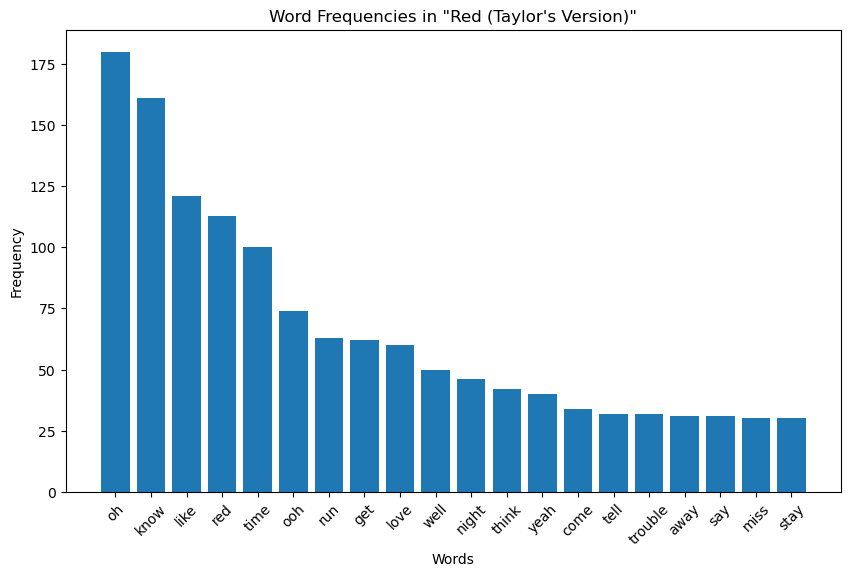

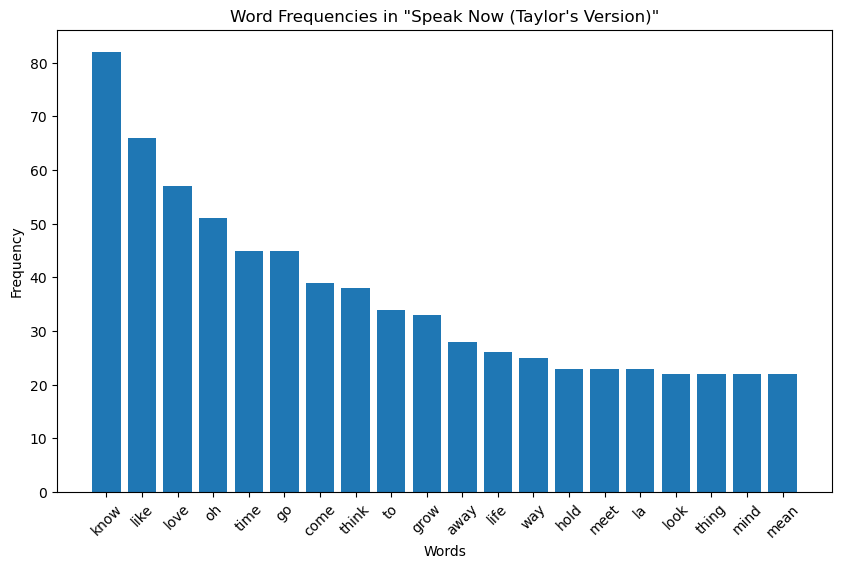

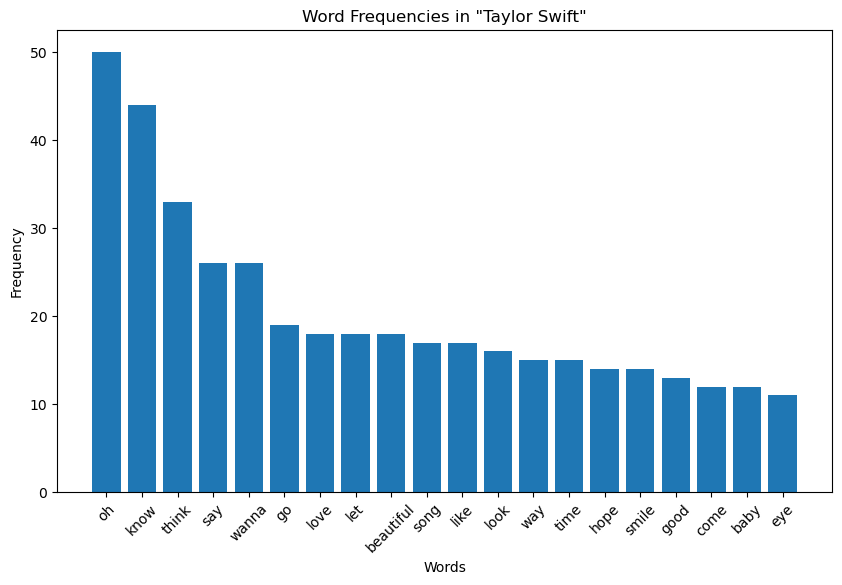

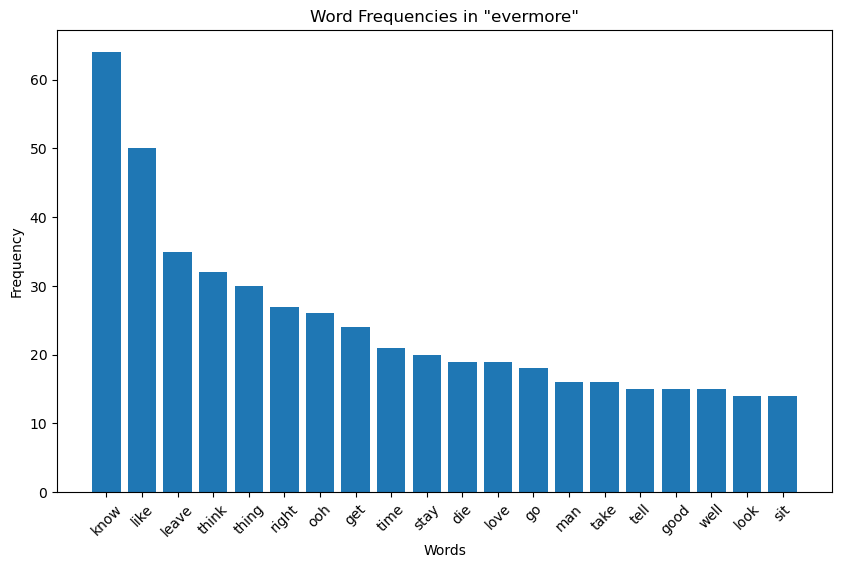

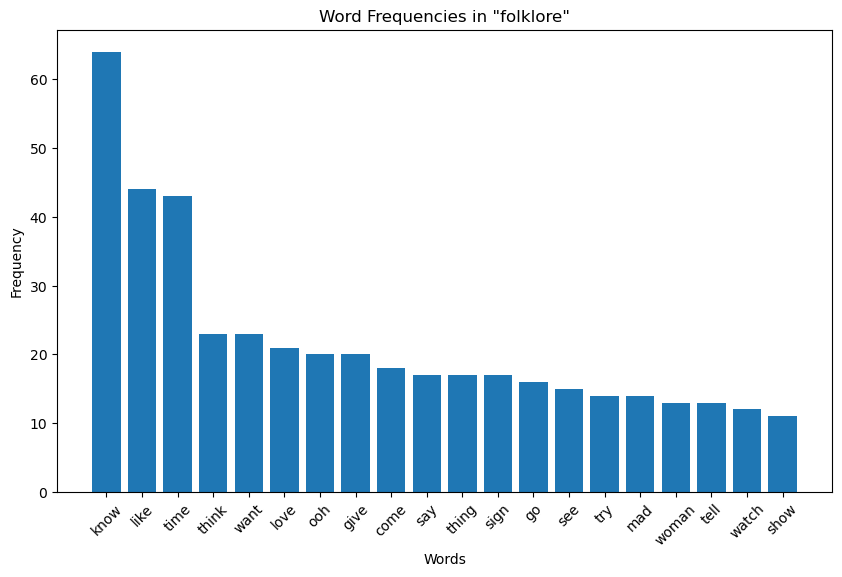

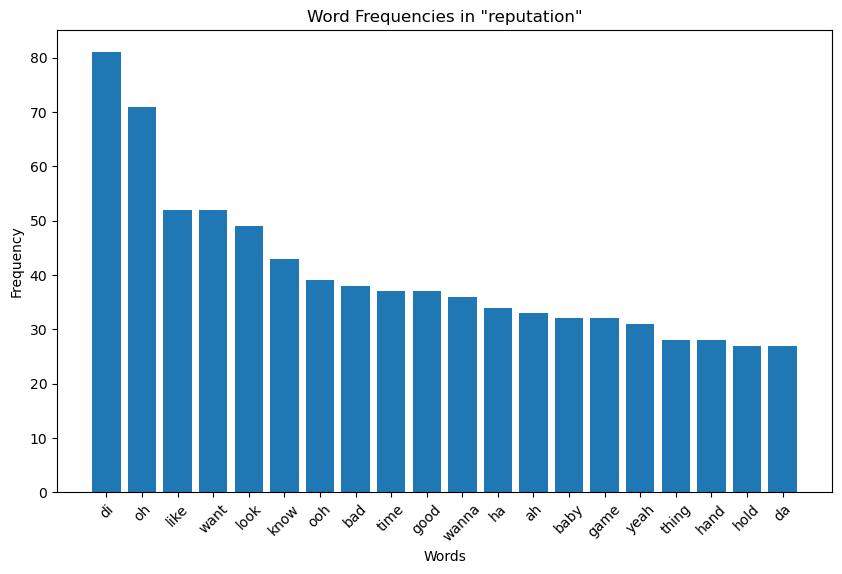

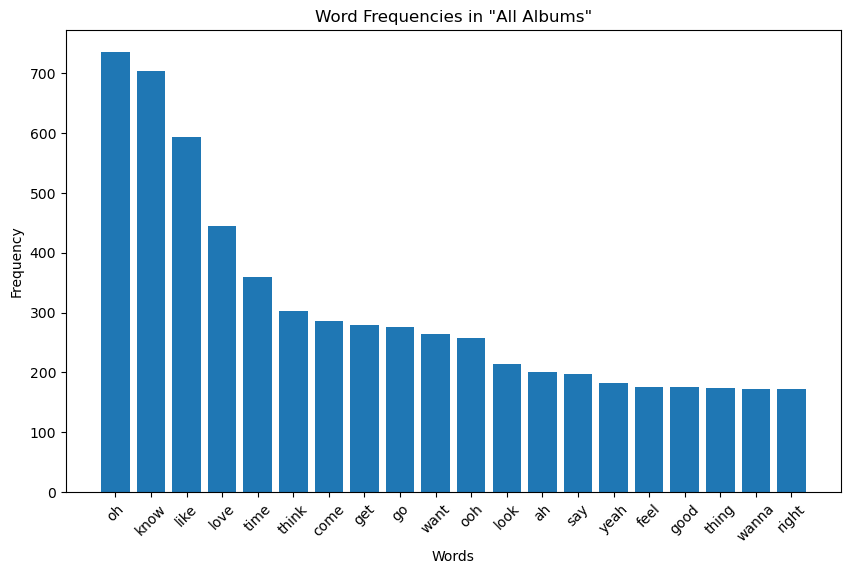

In [41]:
import matplotlib.pyplot as plt

# Function to plot a bar graph for word frequencies
def plot_word_frequencies(word_counts, album_name):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.title(f'Word Frequencies in "{album_name}"')
    plt.show()

# Count the frequency of each word for each album and plot
for album_name, data in df_albums.iterrows():
    count_album_lyrics = Counter(data['lemmatized_lyrics'])
    most_common_words = count_album_lyrics.most_common(20)
    plot_word_frequencies(most_common_words, album_name)

# Optional: Count words across all albums and plot
all_albums_words = [word for sublist in df_albums['lemmatized_lyrics'] for word in sublist]
count_all_albums_lyrics = Counter(all_albums_words)
plot_word_frequencies(count_all_albums_lyrics.most_common(20), "All Albums")


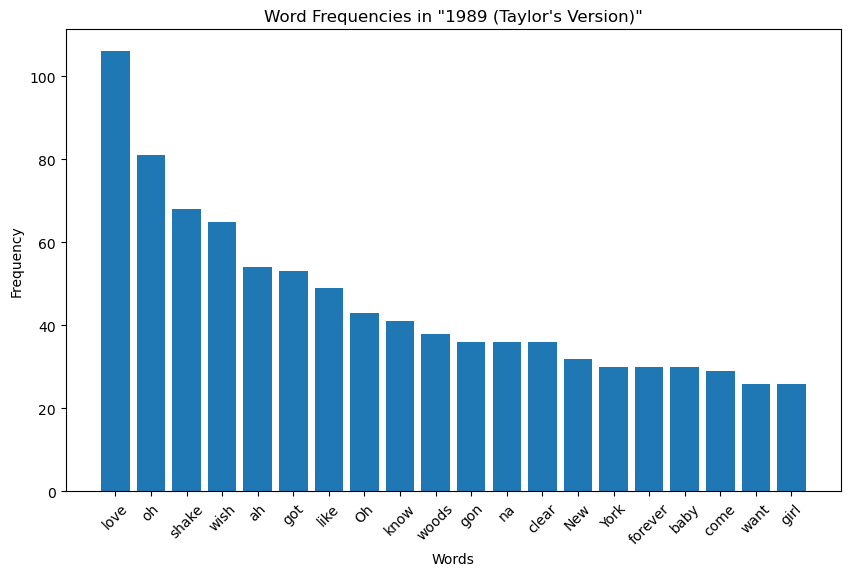

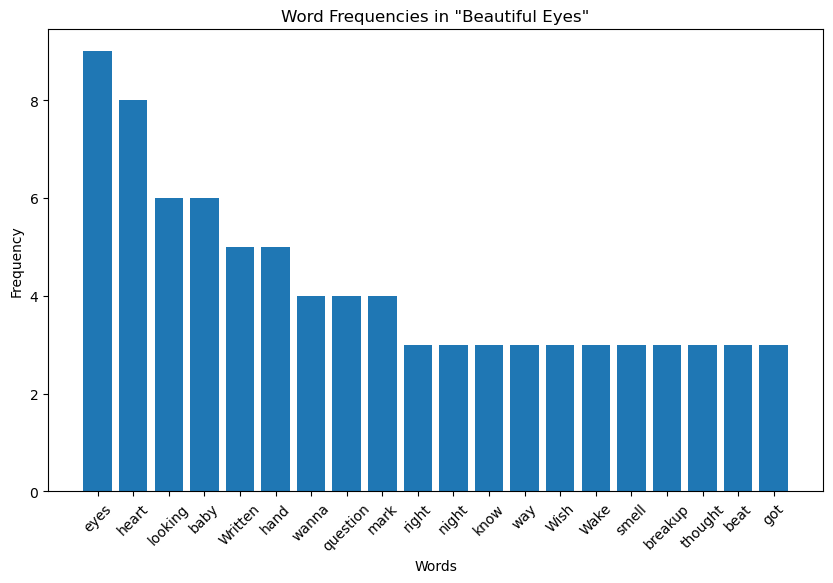

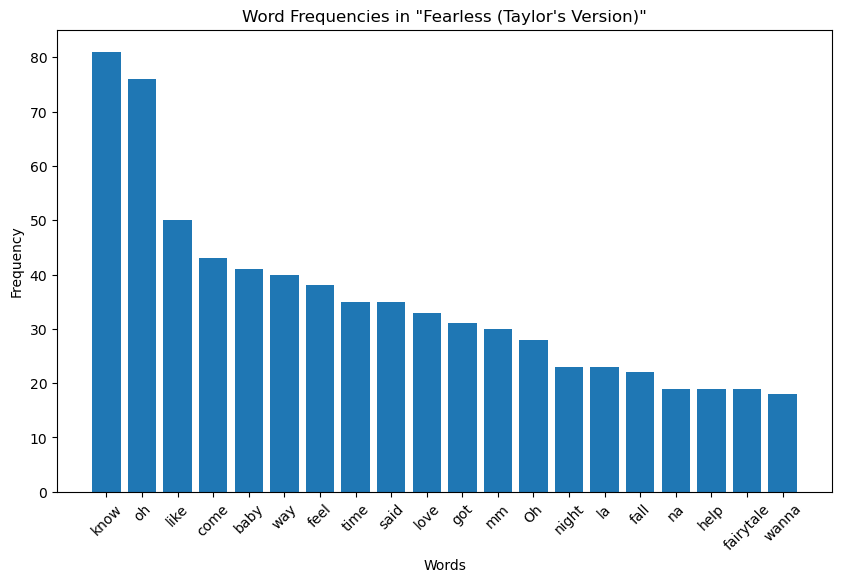

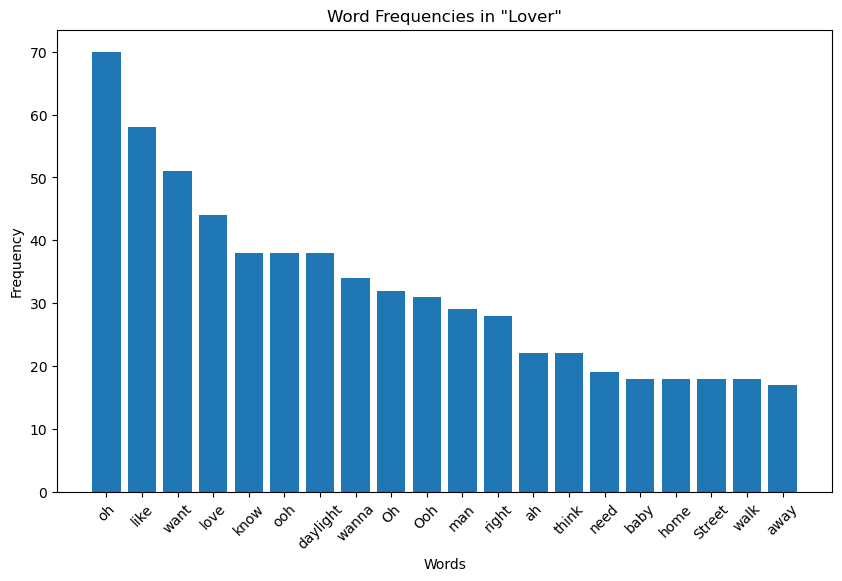

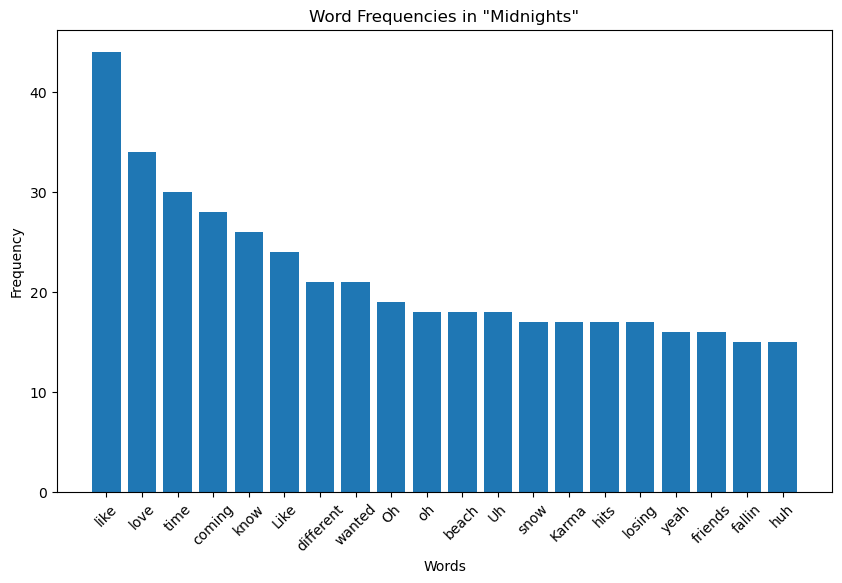

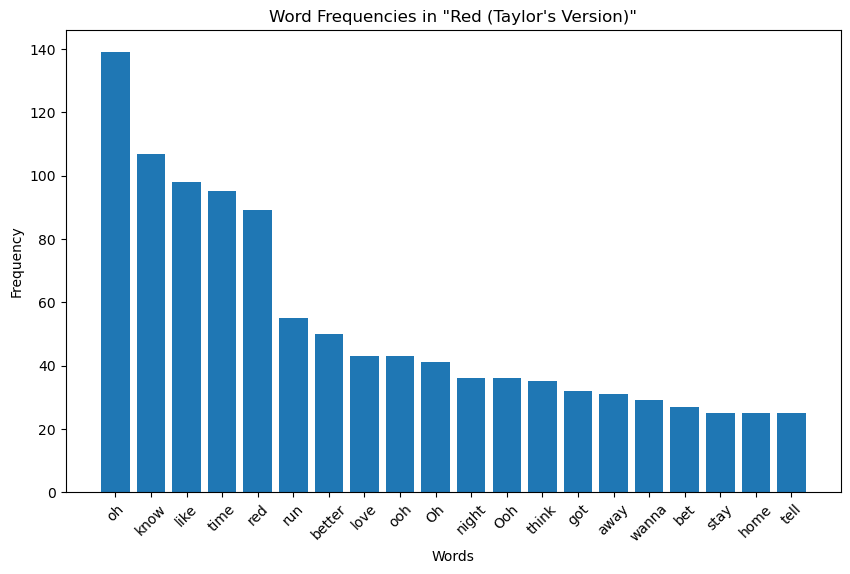

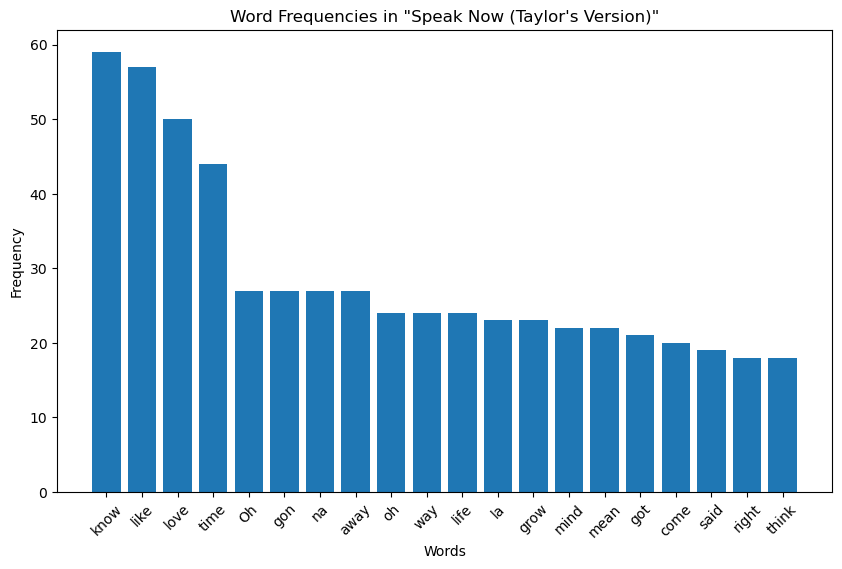

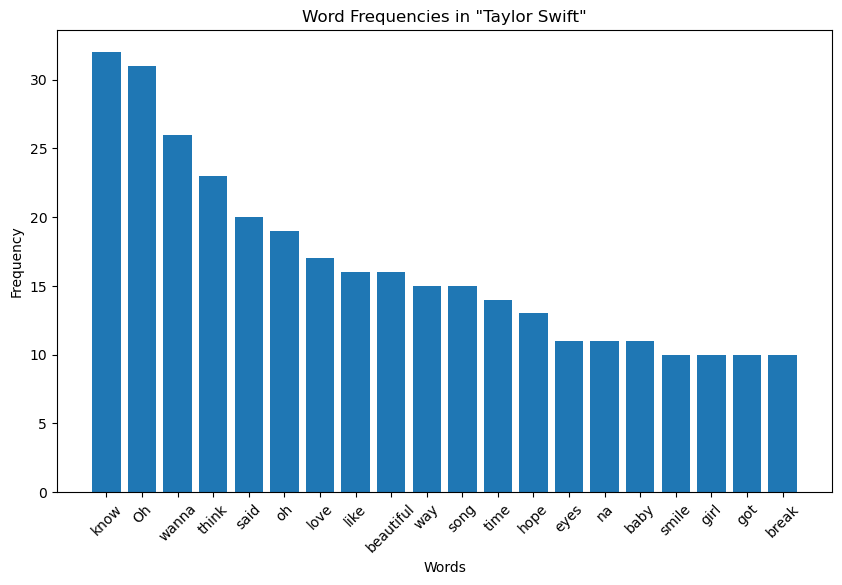

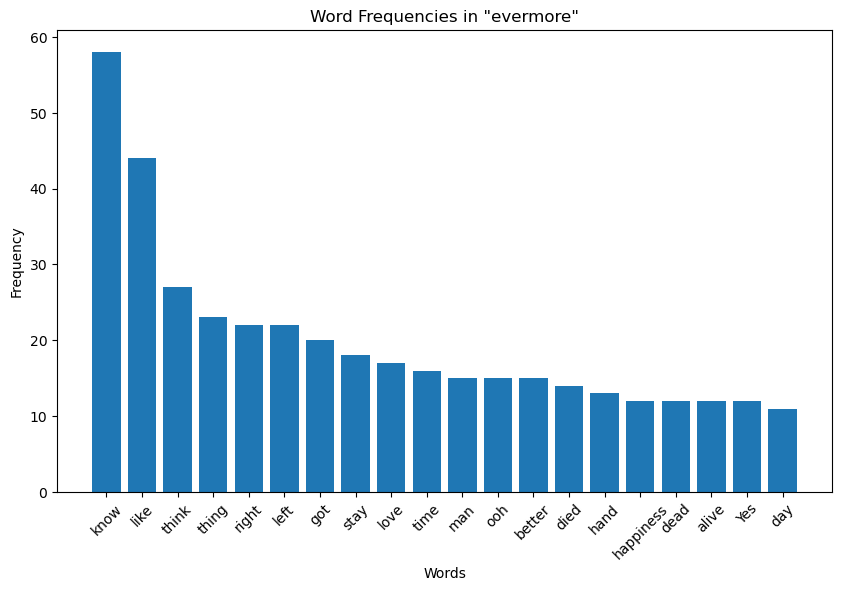

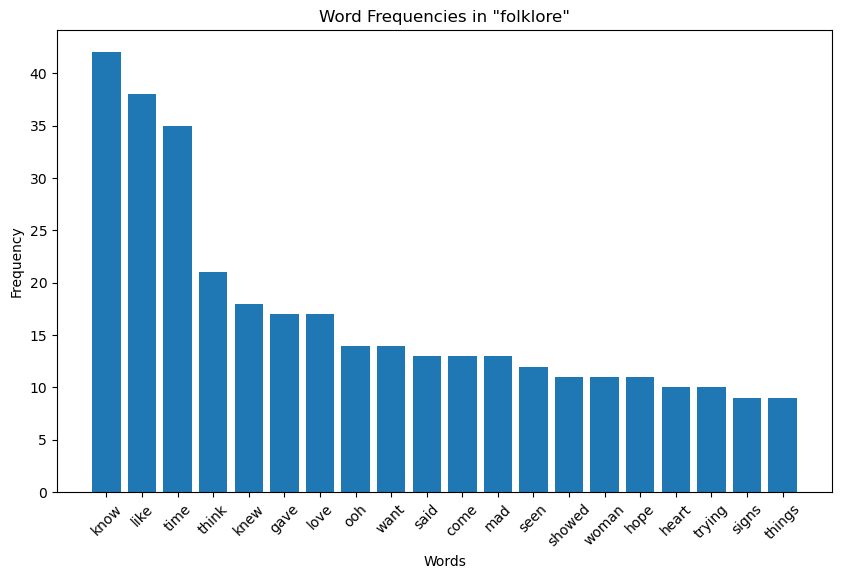

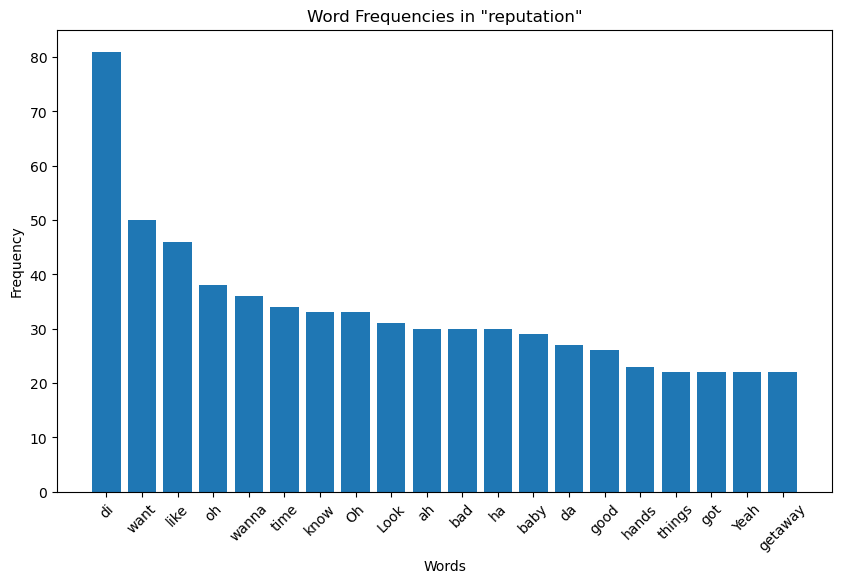

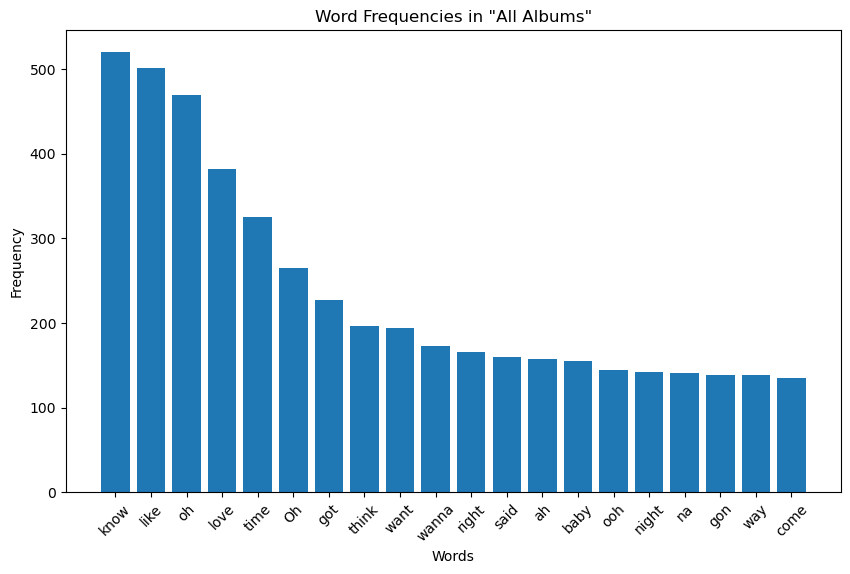

In [44]:
import matplotlib.pyplot as plt

# Function to plot a bar graph for word frequencies
def plot_word_frequencies(word_counts, album_name):
    words, counts = zip(*word_counts)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.title(f'Word Frequencies in "{album_name}"')
    plt.show()

# Count the frequency of each word for each album and plot
for album_name, data in df_albums.iterrows():
    count_album_lyrics = Counter(data['tokenized_lyrics'])
    most_common_words = count_album_lyrics.most_common(20)
    plot_word_frequencies(most_common_words, album_name)

# Optional: Count words across all albums and plot
all_albums_words = [word for sublist in df_albums['tokenized_lyrics'] for word in sublist]
count_all_albums_lyrics = Counter(all_albums_words)
plot_word_frequencies(count_all_albums_lyrics.most_common(20), "All Albums")
